In [1]:
import numpy as np
import pandas as pd
from random import randrange
import sys
sys.path.insert(0, '../SOM-LVQ')
from supervisedSom import supervisedSom
from minisom import MiniSom
import SOM_LVQ

In [2]:
data = pd.read_csv(r"../data/AReM/Dataset1(combined).csv")
x = data.iloc[:, 0:6].values
y = data.iloc[:, 6].values
y[y==7] = 0
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

# use Minmaxscaler because we use euclidean distance
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
x_train = minmax.fit_transform(x_train)
x_test = minmax.transform(x_test)

C:\Users\Thend\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
# train = pd.read_csv(r"..\data\SD-2X_rocktype.csv")
# x_train = train.iloc[:, 0:6].values
# y_train = train.iloc[:, 6].values
# y_train[y_train==4] = 0

In [4]:
# from sklearn.preprocessing import MinMaxScaler
# minmax = MinMaxScaler()
# x_train = minmax.fit_transform(x_train)

In [5]:
# test = pd.read_csv(r"..\data\SD-3X_rocktype.csv")
# x_test = test.iloc[:, 0:6].values
# y_test = test.iloc[:, 6].values
# y_test[y_test==4] = 0
# x_test = minmax.transform(x_test)

In [6]:
# Create a random subsample from the dataset with replacement
def subsample(x, y, ratio):
    sample_x = list()
    sample_y = list()
    n_sample = round(len(x) * ratio)
    while len(sample_x) < n_sample:
        index = randrange(len(x))
        sample_x.append(x[index])
        sample_y.append(y[index])
    return [np.asarray(sample_x), np.asarray(sample_y)]

In [7]:
# Bootstrap Aggregation Algorithm
def bagging(x_train, y_train, x_test, sample_size, n_LVQ):
    trees = list()
    for i in range(n_LVQ):
        sample = subsample(x_train, y_train, sample_size)
#         lvq = LVQ.LVQ(sample[0], sample[1], n_classes=4, p_vectors=[], n_neurons=25)
#         y_pred = [lvq.predict(instance) for instance in x_test]
        som1 = MiniSom(x = 25, y = 25, input_len = 6, sigma = 1.0, learning_rate = 0.5)
        som1.random_weights_init(sample[0])
        som1.train_random(data = sample[0], num_iteration = 100)
        suso1 = supervisedSom(som1, sample[0], sample[1])
        label1= suso1.visualSom()
#         propa1 = suso1.propabilitySom()
        taggings1 = suso1.taggingSom()
        p_vectors = SOM_LVQ.init_LVQ_pvectors(som1, taggings1, sample[0], sample[1])
        lvq1 = SOM_LVQ.SOM_LVQ(sample[0], sample[1], n_classes=7, n_neurons=35, p_vectors=p_vectors, epsilon=0.9, epsilon_dec_factor=0.001)
        neurons = lvq1.fit(sample[0], sample[1])
        predicted_y1 = [suso1.predict(instance) for instance in x_test]
        trees.append(predicted_y1)
    return(np.asarray(trees))

In [8]:
# Make a prediction with a list of bagged trees
def bagging_predict(predictions, n_row, n_LVQ):
    return [np.bincount([predictions[j][i] for j in range(n_LVQ)]).argmax() for i in range(n_row)]

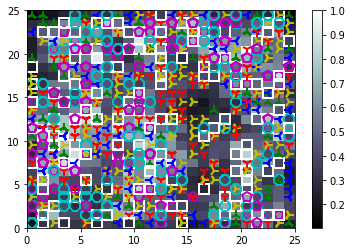

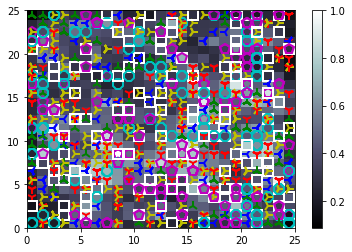

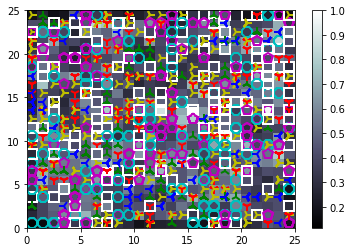

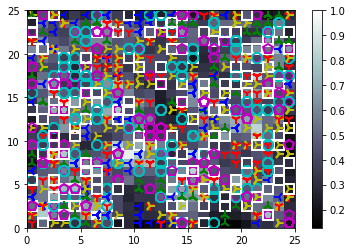

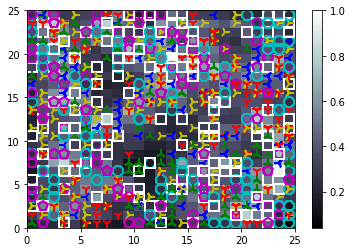

In [9]:
a = bagging(x_train, y_train, x_test, sample_size=1, n_LVQ=5)
y_pred = bagging_predict(a, n_row=len(a[0]), n_LVQ=5)

In [12]:
from sklearn.metrics import classification_report
print (classification_report(y_test, y_pred, target_names=['0', '1', '2', '3', '4', '5', '6']))

             precision    recall  f1-score   support

          0       0.57      0.61      0.59       119
          1       0.92      0.88      0.90       124
          2       0.90      0.94      0.92       129
          3       0.48      0.39      0.43       130
          4       0.47      0.55      0.51       124
          5       0.62      0.60      0.61       107
          6       0.59      0.59      0.59       107

avg / total       0.65      0.65      0.65       840

